In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy
import math
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from scipy.sparse.linalg import svds

# Reading data

In [7]:
users=pd.read_csv('Users.csv',encoding='latin1')
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [8]:
books=pd.read_csv('Books.csv',encoding='ISO-8859-1')
books.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [9]:
ratings = pd.read_csv('Ratings.csv', encoding='latin1', error_bad_lines=False)
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [10]:
users.shape

(278858, 3)

In [11]:
books.shape

(19792, 8)

In [12]:
ratings.shape

(753375, 3)

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [14]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19792 entries, 0 to 19791
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ISBN                 19792 non-null  object
 1   Book-Title           19792 non-null  object
 2   Book-Author          19792 non-null  object
 3   Year-Of-Publication  19792 non-null  int64 
 4   Publisher            19792 non-null  object
 5   Image-URL-S          19792 non-null  object
 6   Image-URL-M          19791 non-null  object
 7   Image-URL-L          19791 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.2+ MB


In [15]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753375 entries, 0 to 753374
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      753375 non-null  int64  
 1   ISBN         753374 non-null  object 
 2   Book-Rating  753374 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 17.2+ MB


In [16]:
users.duplicated().sum()

0

In [17]:
books.duplicated().sum()

0

In [18]:
ratings.duplicated().sum()

0

In [19]:
# Dataset Columns
print(f'Columns in Users: {users.columns}')
print(f'Columns in Books: {books.columns}')
print(f'Columns in Ratings: {ratings.columns}')

Columns in Users: Index(['User-ID', 'Location', 'Age'], dtype='object')
Columns in Books: Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')
Columns in Ratings: Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')


In [20]:
def unique_values(dataset):
    list_unique_valeus = [dataset[col].nunique() for col in dataset.columns]
    list_cols = dataset.columns.tolist()
    data = list(zip(list_cols,list_unique_valeus))
    df = pd.DataFrame(data,columns = ['Column','No of Unique Values'])
    return df

In [21]:
unique_values(users)

,Column,No of Unique Values
0,User-ID,278858
1,Location,57339
2,Age,165


In [22]:
unique_values(ratings)

,Column,No of Unique Values
0,User-ID,69513
1,ISBN,262744
2,Book-Rating,11


In [23]:
unique_values(books)

,Column,No of Unique Values
0,ISBN,19792
1,Book-Title,18611
2,Book-Author,10437
3,Year-Of-Publication,69
4,Publisher,2681
5,Image-URL-S,19788
6,Image-URL-M,19787
7,Image-URL-L,19787


# Data Pre-Processing and Cleaning

In [24]:
merged_df=pd.merge(users,ratings,on='User-ID')
merged_df=pd.merge(merged_df,books,on='ISBN')

In [25]:
merged_df.head()

,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,2,"stockton, california, usa",18.0,0195153448,0.0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,8,"timmins, ontario, canada",NaN,0002005018,5.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,11400,"ottawa, ontario, canada",49.0,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
3,11676,"n/a, n/a, n/a",NaN,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
4,41385,"sudbury, ontario, canada",NaN,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [26]:
merged_df.columns

Index(['User-ID', 'Location', 'Age', 'ISBN', 'Book-Rating', 'Book-Title',
       'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S',
       'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [27]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256852 entries, 0 to 256851
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              256852 non-null  int64  
 1   Location             256852 non-null  object 
 2   Age                  183294 non-null  float64
 3   ISBN                 256852 non-null  object 
 4   Book-Rating          256852 non-null  float64
 5   Book-Title           256852 non-null  object 
 6   Book-Author          256852 non-null  object 
 7   Year-Of-Publication  256852 non-null  int64  
 8   Publisher            256852 non-null  object 
 9   Image-URL-S          256852 non-null  object 
 10  Image-URL-M          256848 non-null  object 
 11  Image-URL-L          256848 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 25.5+ MB


In [28]:
merged_df.shape

(256852, 12)

In [29]:
merged_df.duplicated().sum()

0

In [30]:
merged_df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)

In [31]:
merged_df.columns= merged_df.columns.str.replace('-', '_')

In [32]:
merged_df.columns

Index(['User_ID', 'Location', 'Age', 'ISBN', 'Book_Rating', 'Book_Title',
       'Book_Author', 'Year_Of_Publication', 'Publisher'],
      dtype='object')

In [33]:
# Create a country column at the place of location
merged_df['Country'] = merged_df['Location'].astype(str).apply(lambda x:x.split(',')[-1])
# Drop the location column
merged_df.drop('Location',axis=1,inplace=True) # inplace =True means we are changing original datafram itself

In [34]:
merged_df['Country'].unique()

array([' usa', ' canada', ' n/a', '', ' spain', ' finland', ' portugal',
       ' brazil', ' germany', ' malaysia', ' austria', ' italy',
       ' united kingdom', ' netherlands', ' australia', ' france',
       ' new zealand', ' iran', ' india', ' pakistan', ' taiwan',
       ' singapore', ' argentina', ' romania', ' greece', ' ireland',
       ' philippines', ' belgium', ' philippines"', ' mexico',
       ' south africa', ' burkina faso', ' croatia', ' switzerland',
       ' denmark', ' rwanda', ' yugoslavia', ' turkey', ' china',
       ' japan', ' qatar', ' poland', ' latvia', ' sweden', ' kuwait',
       ' indonesia', ' nepal', ' peru', ' venezuela', ' south korea"',
       ' hong kong', ' united states', ' slovakia', ' norway',
       ' dominican republic', ' bosnia and herzegovina', ' south korea',
       ' macedonia', ' kenya', ' mauritius', ' catalonia', ' guatemala',
       ' euskal herria', ' russia', ' bermuda', ' far away...',
       ' antarctica', ' andorra', ' bulgaria',

In [35]:
merged_df['Country'] = merged_df['Country'].replace(' ','other').replace(' n/a','other')

In [36]:
merged_df['Country'].replace(['','01776','02458','19104','23232','30064','85021','87510','alachua','america','austria','autralia','cananda','geermany','italia','united kindgonm','united sates','united staes','united state','united states','us'],
                           ['other','usa','usa','usa','usa','usa','usa','usa','usa','usa','australia','australia','canada','germany','italy','united kingdom','usa','usa','usa','usa','usa'],inplace=True)


In [37]:
def missing_values(df):
    miss = df.isnull().sum()
    per = df.isnull().mean()
    df = pd.concat([miss,per*100],keys = ['Missing_Values','Percentage'], axis = 1)
    return df

In [38]:
missing_values(merged_df)

,Missing_Values,Percentage
User_ID,0,0.000000
Age,73558,28.638282
ISBN,0,0.000000
Book_Rating,0,0.000000
Book_Title,0,0.000000
Book_Author,0,0.000000
Year_Of_Publication,0,0.000000
Publisher,0,0.000000
Country,0,0.000000


In [39]:
merged_df.head()

,User_ID,Age,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Country
0,2,18.0,0195153448,0.0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,usa
1,8,NaN,0002005018,5.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,canada
2,11400,49.0,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,canada
3,11676,NaN,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,other
4,41385,NaN,0002005018,0.0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,canada


In [40]:
merged_df['Year_Of_Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1989, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978,
       1980, 1952, 1987, 1990, 1981,    0, 1984, 1968, 1961, 1959, 1946,
       1974, 1958, 1976, 1971, 1977, 1975, 1965, 1941, 1970, 1953, 1962,
       1973, 1972, 1960, 1954, 1966, 1920, 1967, 1956, 1942, 1955, 1951,
       1969, 1948, 1963, 1964, 1950, 2005, 1943, 1957, 1937, 1940, 1930,
       1936, 2011, 1925])

In [41]:
merged_df[merged_df['Publisher'].isnull()]
# merged_df.loc[(merged_df['publisher'].isnull()),:]

,User_ID,Age,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Country


In [42]:
missing_values(merged_df)

,Missing_Values,Percentage
User_ID,0,0.000000
Age,73558,28.638282
ISBN,0,0.000000
Book_Rating,0,0.000000
Book_Title,0,0.000000
Book_Author,0,0.000000
Year_Of_Publication,0,0.000000
Publisher,0,0.000000
Country,0,0.000000


# Exploratory Data Analysis

In [43]:
merged_df.corr()

,User_ID,Age,Book_Rating,Year_Of_Publication
User_ID,1.000000,0.015454,-0.026660,0.012710
Age,0.015454,1.000000,-0.027029,0.016186
Book_Rating,-0.026660,-0.027029,1.000000,-0.009942
Year_Of_Publication,0.012710,0.016186,-0.009942,1.000000


Text(0.5, 1.0, 'Find outlier data in Age column')

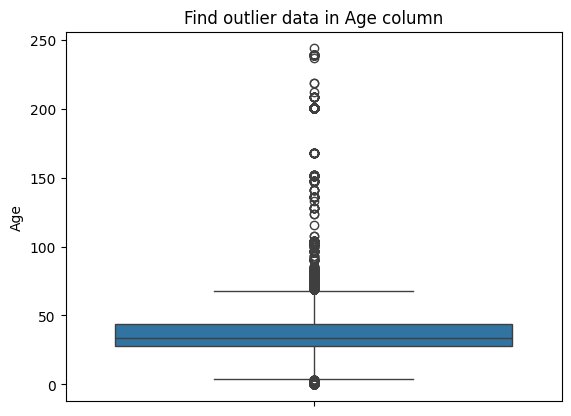

In [44]:
# finding outlier in age
# Box plot for age
sns.boxplot(merged_df['Age']);
plt.title('Find outlier data in Age column')

In [45]:
merged_df.loc[(merged_df.Age > 100) | (merged_df.Age < 5), 'Age'] = np.nan


In [46]:
merged_df.isna().sum()

User_ID                    0
Age                    74457
ISBN                       0
Book_Rating                0
Book_Title                 0
Book_Author                0
Year_Of_Publication        0
Publisher                  0
Country                    0
dtype: int64

In [47]:
merged_df['Age'] = merged_df['Age'].fillna(merged_df.groupby('Country')['Age'].transform('median'))

In [48]:
merged_df.isna().sum()


User_ID                 0
Age                    92
ISBN                    0
Book_Rating             0
Book_Title              0
Book_Author             0
Year_Of_Publication     0
Publisher               0
Country                 0
dtype: int64

In [49]:
merged_df['Age'].fillna(merged_df.Age.mean(),inplace=True)


In [50]:
merged_df.isna().sum()

User_ID                0
Age                    0
ISBN                   0
Book_Rating            0
Book_Title             0
Book_Author            0
Year_Of_Publication    0
Publisher              0
Country                0
dtype: int64

In [51]:
merged_df.loc[merged_df['Year_Of_Publication'] == 'DK Publishing Inc',:]



,User_ID,Age,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Country


In [52]:
merged_df.loc[merged_df.ISBN == '0789466953','Year_Of_Publication'] = 2000
merged_df.loc[merged_df.ISBN == '0789466953','Book_Author'] = "James Buckley"
merged_df.loc[merged_df.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
merged_df.loc[merged_df.ISBN == '0789466953','Book_Title'] = "DK Readers: Creating the X-Men, How Comic merged_df Come to Life (Level 4: Proficient Readers)"
#ISBN '078946697X'
merged_df.loc[merged_df.ISBN == '078946697X','Year_Of_Publication'] = 2000
merged_df.loc[merged_df.ISBN == '078946697X','Book_Author'] = "Michael Teitelbaum"
merged_df.loc[merged_df.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
merged_df.loc[merged_df.ISBN == '078946697X','Book_Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"
merged_df.loc[(merged_df.ISBN == '0789466953') | (merged_df.ISBN == '078946697X'),:]


,User_ID,Age,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Country


In [53]:
merged_df.loc[merged_df['Year_Of_Publication'] == 'Gallimard',:]

,User_ID,Age,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Country


In [54]:
merged_df.loc[merged_df.ISBN == '2070426769','Year_Of_Publication'] = 2003
merged_df.loc[merged_df.ISBN == '2070426769','Book_Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
merged_df.loc[merged_df.ISBN == '2070426769','Publisher'] = "Gallimard"
merged_df.loc[merged_df.ISBN == '2070426769','Book_Title'] = "Peuple du ciel, suivi de 'Les Bergers"
merged_df.loc[merged_df.ISBN == '2070426769',:]


,User_ID,Age,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Country


In [55]:
merged_df['Year_Of_Publication']=pd.to_numeric(merged_df['Year_Of_Publication'], errors='coerce')
merged_df['Year_Of_Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1989, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978,
       1980, 1952, 1987, 1990, 1981,    0, 1984, 1968, 1961, 1959, 1946,
       1974, 1958, 1976, 1971, 1977, 1975, 1965, 1941, 1970, 1953, 1962,
       1973, 1972, 1960, 1954, 1966, 1920, 1967, 1956, 1942, 1955, 1951,
       1969, 1948, 1963, 1964, 1950, 2005, 1943, 1957, 1937, 1940, 1930,
       1936, 2011, 1925])

In [56]:
merged_df.loc[(merged_df['Year_Of_Publication'] > 2006) | (merged_df['Year_Of_Publication'] == 0),'Year_Of_Publication'] = np.NAN
merged_df['Year_Of_Publication'].fillna(round(merged_df['Year_Of_Publication'].median()), inplace=True)


In [57]:
merged_df.isna().sum()


User_ID                0
Age                    0
ISBN                   0
Book_Rating            0
Book_Title             0
Book_Author            0
Year_Of_Publication    0
Publisher              0
Country                0
dtype: int64

In [58]:
merged_df.loc[merged_df.Publisher.isnull(),:]


,User_ID,Age,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Country


In [59]:
merged_df.Publisher.fillna('other',inplace=True)


In [60]:
merged_df.loc[merged_df['Book_Author'].isnull(),:]



,User_ID,Age,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Country


In [61]:
merged_df['Book_Author'].fillna('other',inplace=True)


In [62]:
merged_df.isna().sum()

User_ID                0
Age                    0
ISBN                   0
Book_Rating            0
Book_Title             0
Book_Author            0
Year_Of_Publication    0
Publisher              0
Country                0
dtype: int64

In [63]:
missing_values(merged_df)

,Missing_Values,Percentage
User_ID,0,0.0
Age,0,0.0
ISBN,0,0.0
Book_Rating,0,0.0
Book_Title,0,0.0
Book_Author,0,0.0
Year_Of_Publication,0,0.0
Publisher,0,0.0
Country,0,0.0


In [64]:
merged_df.shape

(256852, 9)

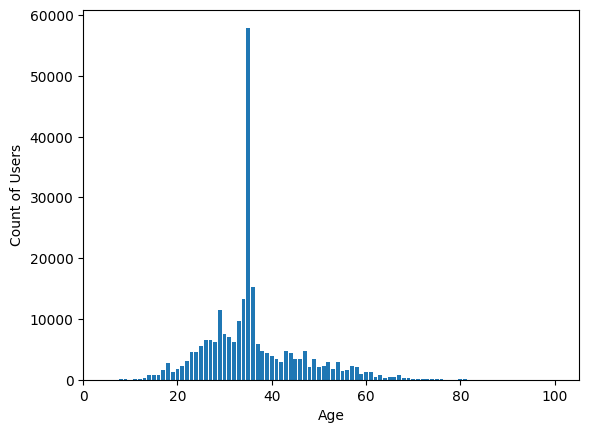

In [65]:
u = merged_df.Age.value_counts().sort_index()
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('Count of Users')
plt.xlim(xmin = 0)
plt.show()

Text(0.5, 1.0, 'Top 10 Publishers')

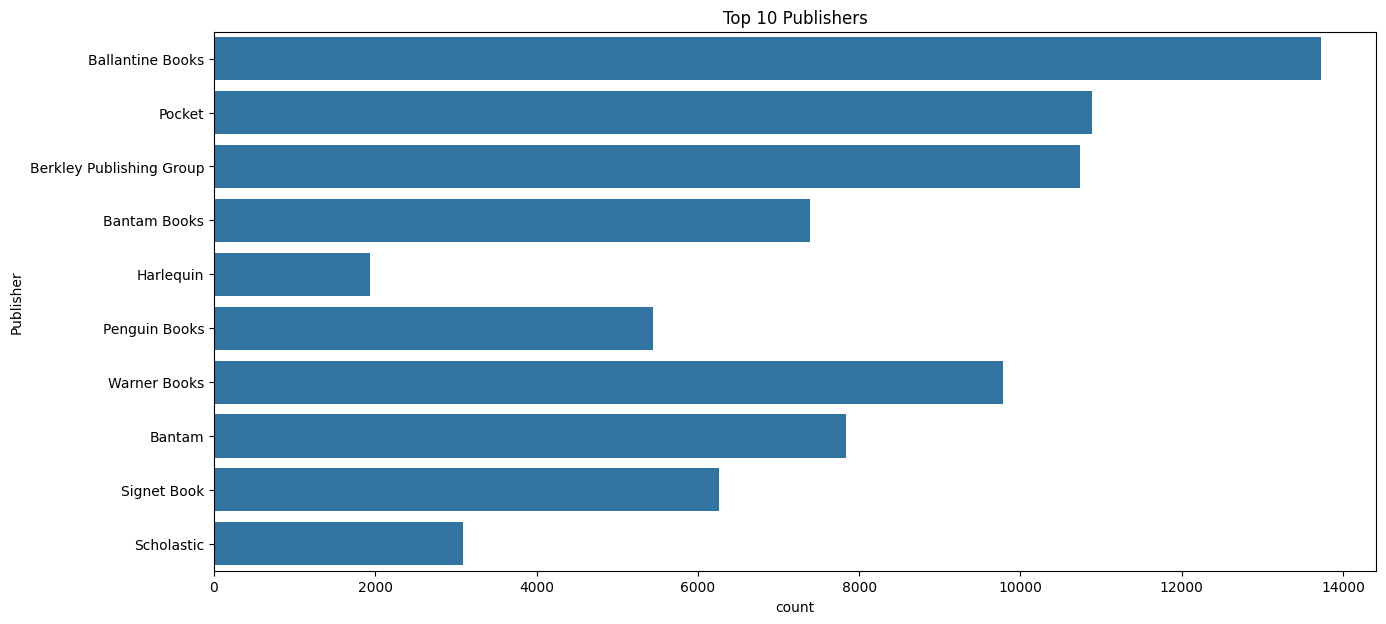

In [66]:
plt.figure(figsize=(15,7))
sns.countplot(y='Publisher',data=merged_df,order=pd.value_counts(books['Publisher']).iloc[:10].index)
plt.title('Top 10 Publishers')

Text(0.5, 1.0, 'Top 10 Authors')

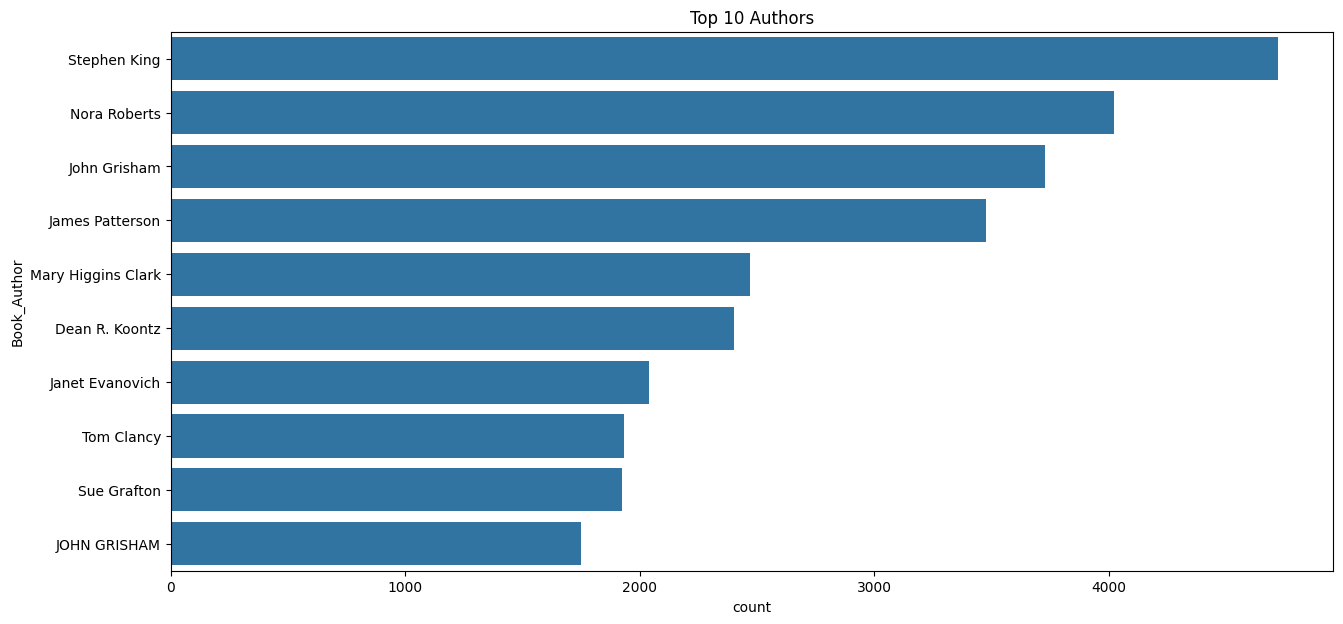

In [67]:
plt.figure(figsize=(15,7))
sns.countplot(y='Book_Author',data=merged_df,order=pd.value_counts(merged_df['Book_Author']).iloc[:10].index)
plt.title('Top 10 Authors')

Text(0.5, 1.0, 'Age Distribution Plot')

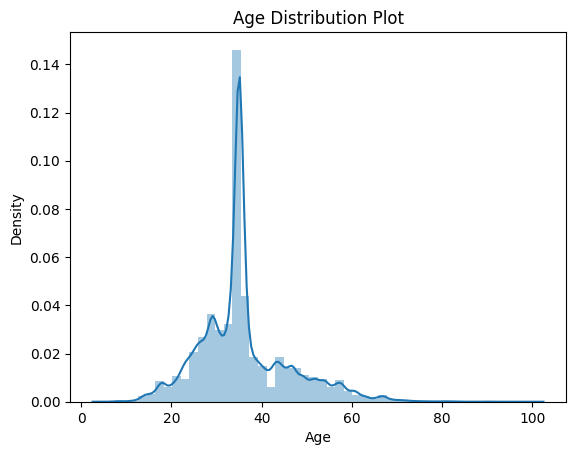

In [68]:
sns.distplot(merged_df.Age)
plt.title('Age Distribution Plot')

Text(0.5, 1.0, 'Count of users Country wise')

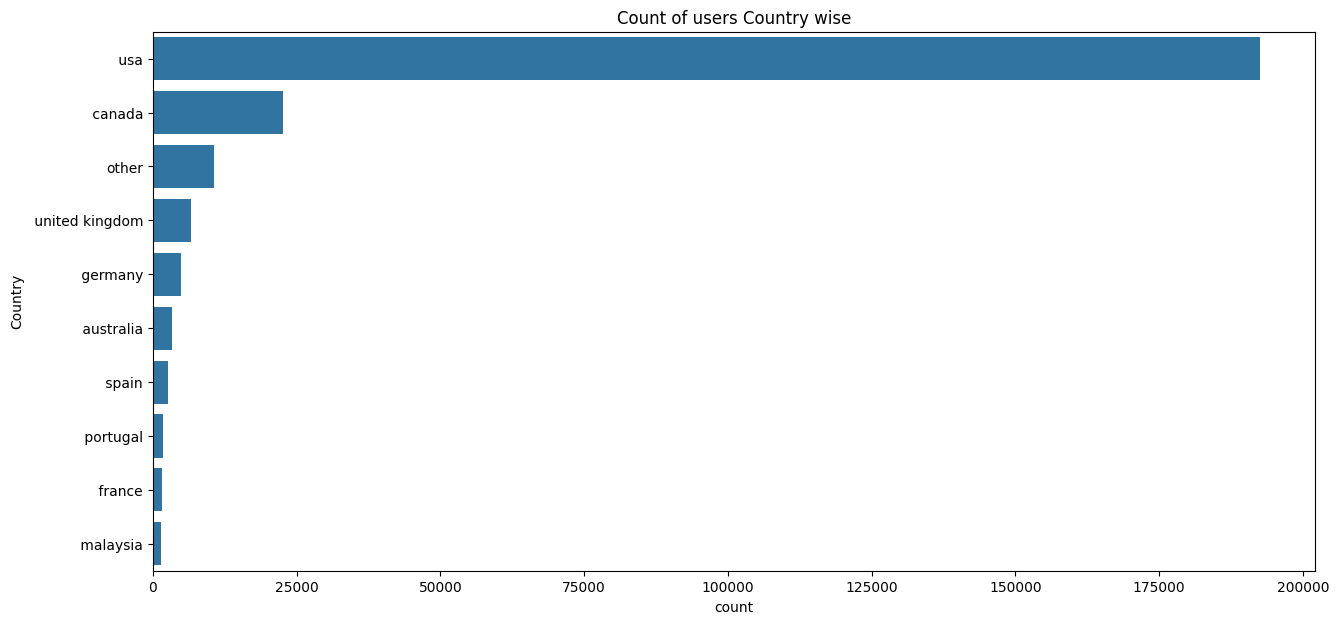

In [69]:
plt.figure(figsize=(15,7))
sns.countplot(y='Country',data=merged_df,order=pd.value_counts(merged_df['Country']).iloc[:10].index)
plt.title('Count of users Country wise')


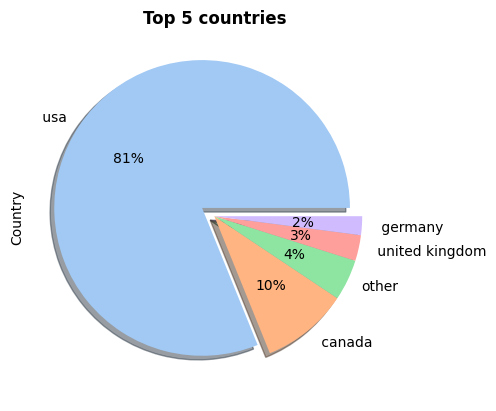

In [70]:
# Pie Graph of top five countires.
palette_color = sns.color_palette('pastel')
explode = (0.1, 0, 0, 0, 0)
merged_df.Country.value_counts().iloc[:5].plot(kind='pie', colors=palette_color, autopct='%.0f%%', explode=explode, shadow=True)
plt.title('Top 5 countries', fontweight='bold');

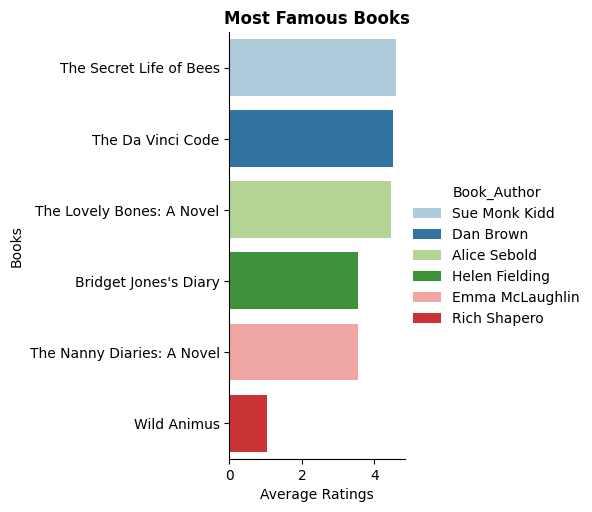

In [71]:
book_rating = merged_df.groupby(['Book_Title','Book_Author'])['Book_Rating'].agg(['count','mean']).sort_values(by='mean', ascending=False).reset_index()
sns.catplot(x='mean', y='Book_Title', data=book_rating[book_rating['count']>500][:10], kind='bar', palette = 'Paired',hue='Book_Author' )
plt.xlabel('Average Ratings')
plt.ylabel('Books')
plt.title('Most Famous Books', fontweight='bold');

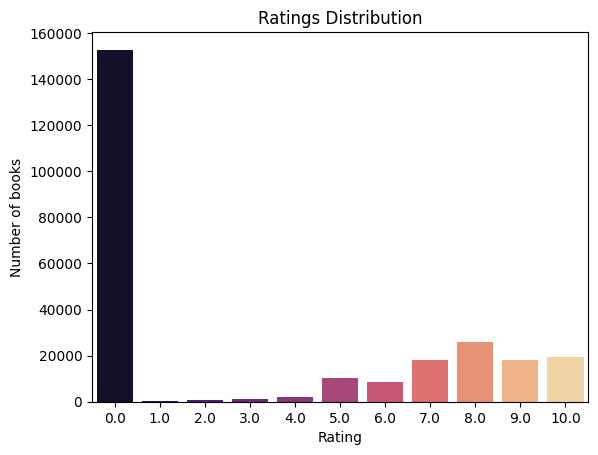

In [72]:
sns.barplot(x = merged_df['Book_Rating'].value_counts().index,y = merged_df['Book_Rating'].value_counts().values,palette = 'magma').set(title="Ratings Distribution", xlabel = "Rating",ylabel = 'Number of books')
plt.show();

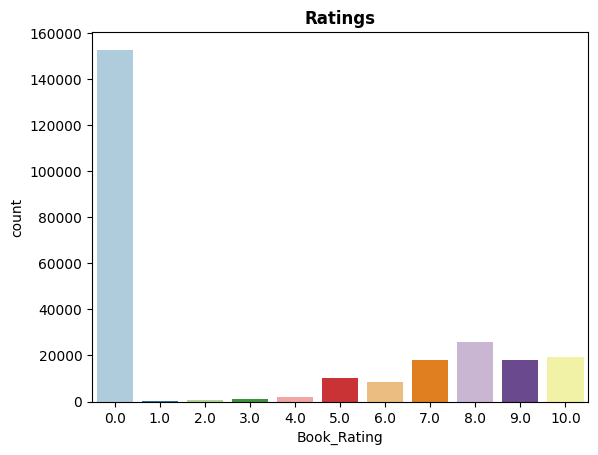

In [73]:
sns.countplot(x="Book_Rating",palette='Paired',data=merged_df)
plt.title("Ratings",fontweight='bold');

In [74]:
merged_df.corr()

,User_ID,Age,Book_Rating,Year_Of_Publication
User_ID,1.000000,0.044828,-0.026660,0.027560
Age,0.044828,1.000000,-0.020865,0.043397
Book_Rating,-0.026660,-0.020865,1.000000,0.004436
Year_Of_Publication,0.027560,0.043397,0.004436,1.000000


<Axes: >

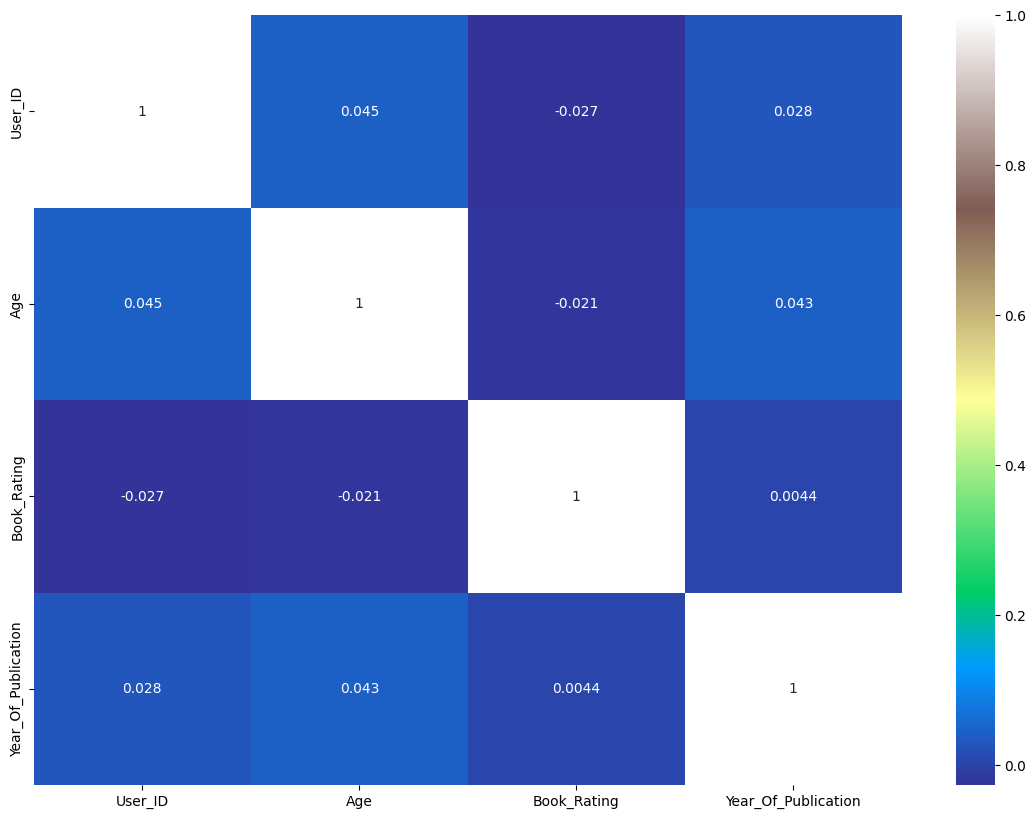

In [75]:
plt.figure(figsize=(14,10))
sns.heatmap(merged_df.corr(),annot=True,cmap='terrain')

# Popularity Based Recommender System

In [76]:
merged_df['Avg_Ratings'] =  merged_df.groupby('Book_Title')['Book_Rating'].transform('mean')

In [77]:
merged_df['No_Of_Ratings'] = merged_df.groupby('Book_Title')['Book_Rating'].transform('count')

In [78]:
popular_df = merged_df[['Book_Title','Avg_Ratings','No_Of_Ratings']]

In [79]:
popular_df.drop_duplicates('Book_Title',inplace=True)

In [80]:
popular_df.head()

,Book_Title,Avg_Ratings,No_Of_Ratings
0,Classical Mythology,0.000000,1
1,Clara Callan,3.900000,10
11,Decision in Normandy,5.000000,3
14,Flu: The Story of the Great Influenza Pandemic...,3.428571,7
21,The Mummies of Urumchi,0.000000,1


In [81]:
popular_df = popular_df[popular_df['No_Of_Ratings']>200].sort_values('Avg_Ratings',ascending=False)

In [82]:
popular_df.head(10)

,Book_Title,Avg_Ratings,No_Of_Ratings
21803,Harry Potter and the Goblet of Fire (Book 4),5.837607,234
21918,Harry Potter and the Order of the Phoenix (Boo...,5.733333,210
21530,Harry Potter and the Prisoner of Azkaban (Book 3),5.641026,273
21174,Harry Potter and the Chamber of Secrets (Book 2),5.169761,377
83279,Harry Potter and the Sorcerer's Stone (Harry P...,5.032086,374
24963,The Fellowship of the Ring (The Lord of the Ri...,4.750000,240
2609,To Kill a Mockingbird,4.743827,324
18375,The Secret Life of Bees,4.605825,515
5841,The Five People You Meet in Heaven,4.562290,297
43342,The Da Vinci Code,4.515000,600


# Collaborative Filtering

# Item Based

In [83]:
merged_df.shape

(256852, 11)

In [84]:
merged_df.columns

Index(['User_ID', 'Age', 'ISBN', 'Book_Rating', 'Book_Title', 'Book_Author',
       'Year_Of_Publication', 'Publisher', 'Country', 'Avg_Ratings',
       'No_Of_Ratings'],
      dtype='object')

In [85]:
x = merged_df.groupby('User_ID').count()['Book_Rating'] > 180

In [86]:
x[x]

User_ID
254       True
2276      True
2766      True
2977      True
3363      True
          ... 
177458    True
178667    True
182085    True
277427    True
278418    True
Name: Book_Rating, Length: 173, dtype: bool

In [87]:
merged_df['User_ID'].isin(x[x].index)

0         False
1         False
2         False
3          True
4         False
          ...  
256847    False
256848    False
256849    False
256850    False
256851    False
Name: User_ID, Length: 256852, dtype: bool

In [88]:
print("Shape of merged dataframe : ",merged_df.shape)

Shape of merged dataframe :  (256852, 11)


In [89]:
merged_df = merged_df[merged_df['Book_Rating']!=0]

In [90]:
print("Shape of merged new dataframe : ",merged_df.shape)

Shape of merged new dataframe :  (104146, 11)


In [91]:
x = merged_df.groupby('User_ID').count()['Book_Rating'] >180
filtered_df = merged_df[merged_df['User_ID'].isin(x[x].index)]

In [92]:
y = merged_df.groupby('Book_Title').count()['Book_Rating'] >50
filtered_df = filtered_df[filtered_df['Book_Title'].isin(y[y].index)]

In [93]:
filtered_df.shape

(873, 11)

In [94]:
filtered_df.head()

,User_ID,Age,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Country,Avg_Ratings,No_Of_Ratings
23,11676,36.0,0399135782,9.0,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,other,2.930693,202
79,11676,36.0,0440234743,9.0,The Testament,John Grisham,1999.0,Dell,other,3.340741,405
349,11676,36.0,0452264464,8.0,Beloved (Plume Contemporary Fiction),Toni Morrison,1994.0,Plume,other,3.609756,123
598,11676,36.0,0971880107,6.0,Wild Animus,Rich Shapero,2004.0,Too Far,other,1.035627,1628
2282,11676,36.0,0345417623,10.0,Timeline,MICHAEL CRICHTON,2000.0,Ballantine Books,other,3.763006,346


In [95]:
pt = filtered_df.pivot_table(index='Book_Title',columns='User_ID',values='Book_Rating').fillna(0)
pt

User_ID,2276,4385,6251,6575,11676,16795,35859,60244,95359,98391,104636,114368,135149,153662,158295
Book_Title,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,10.0,8.0,0.0,9.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,9.0,9.0,7.0,0.0,8.0,0.0,10.0,0.0,0.0,0.0,0.0
2nd Chance,10.0,0.0,0.0,0.0,7.5,0.0,7.5,0.0,0.0,9.0,0.0,7.0,0.0,0.0,6.0
A Bend in the Road,0.0,0.0,0.0,1.0,6.5,8.0,0.0,0.0,0.0,8.0,0.0,0.0,9.0,0.0,0.0
"A Child Called \It\"": One Child's Courage to Survive""",0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wicked: The Life and Times of the Wicked Witch of the West,0.0,0.0,0.0,9.0,9.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wild Animus,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wish You Well,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0


In [96]:
similarity_scores_books = cosine_similarity(pt)

In [97]:
similarity_scores_books

array([[1.        , 0.67280651, 0.20754811, ..., 0.42497295, 0.5383819 ,
        0.29250578],
       [0.67280651, 1.        , 0.31851704, ..., 0.36685776, 0.41311822,
        0.61322768],
       [0.20754811, 0.31851704, 1.        , ..., 0.30429804, 0.        ,
        0.35306631],
       ...,
       [0.42497295, 0.36685776, 0.30429804, ..., 1.        , 0.        ,
        0.4288593 ],
       [0.5383819 , 0.41311822, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.29250578, 0.61322768, 0.35306631, ..., 0.4288593 , 0.        ,
        1.        ]])

In [98]:
similarity_scores=cosine_similarity(pt)

In [99]:
for i,j in enumerate([1,2,3]):
    print(f"Index : {i} value {j}")

Index : 0 value 1
Index : 1 value 2
Index : 2 value 3


In [100]:
def recommend_book(book_name):
  """
  Description: It takes a book name and return data frame with similarity score
  Function: recommend_book
  Argument: book_name
  Return type : dataframe
  """
  index = np.where(pt.index == book_name)[0][0] # finding index of same book
  similar_books = sorted(list(enumerate(similarity_scores[index])), key = lambda x:x[1], reverse = True)[1:6] # creating the list tuple of index with respect to similarity score

  # print(similar_books)

  print("\n----------------Recommended books-----------------\n")
  for i in similar_books:
    print(pt.index[i[0]])
  print("\n.....................................................\n")
  return find_similarity_score(similar_books,pt)


In [101]:
def find_similarity_score(similarity_scores,pivot_table):

  """
  Description: It takes similarity_Score and pivot table and return dataframe.
  function : find_similarity_Score
  Output : dataframe
  Argument  similarity_score and pivot table
  """
  list_book = []
  list_sim = []
  for i in similarity_scores:
    index_ = i[0]
    sim_ = i[1]
    list_sim.append(sim_)
    # list_book.append(pivot_table[pivot_table.index == index_]['Book-Title'][index_])
    list_book.append(pivot_table.iloc[index_,:].name)

    df = pd.DataFrame(list(zip(list_book, list_sim)),
               columns =['Book', 'Similarity'])
  # df =pd.DataFrame([list_book, list_sim], columns = ["Book",'Similarity_Score'])
  return df

In [102]:
recommend_book('Harry Potter and the Prisoner of Azkaban (Book 3)')


----------------Recommended books-----------------

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
One for the Money (Stephanie Plum Novels (Paperback))
The Client
Snow Falling on Cedars

.....................................................



,Book,Similarity
0,Harry Potter and the Goblet of Fire (Book 4),0.925300
1,Harry Potter and the Chamber of Secrets (Book 2),0.762050
2,One for the Money (Stephanie Plum Novels (Pape...,0.751200
3,The Client,0.738191
4,Snow Falling on Cedars,0.723455


In [103]:
recommend_book('Harry Potter and the Prisoner of Azkaban (Book 3)')


----------------Recommended books-----------------

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
One for the Money (Stephanie Plum Novels (Paperback))
The Client
Snow Falling on Cedars

.....................................................



,Book,Similarity
0,Harry Potter and the Goblet of Fire (Book 4),0.925300
1,Harry Potter and the Chamber of Secrets (Book 2),0.762050
2,One for the Money (Stephanie Plum Novels (Pape...,0.751200
3,The Client,0.738191
4,Snow Falling on Cedars,0.723455


In [104]:
df_matrix= csr_matrix(pt.values)
df_matrix

<283x15 sparse matrix of type '<class 'numpy.float64'>'
	with 785 stored elements in Compressed Sparse Row format>

# Building KNN Model

In [105]:
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors=5)
knn.fit(pt)


NearestNeighbors(algorithm='brute', metric='cosine')

In [106]:
def recommend_book(book, n_values=11):

  distances, indices = knn.kneighbors(pt.loc[book,:].values.reshape(1, -1), n_neighbors = n_values)
  dist = distances.flatten().tolist()
  books = []
  for i in range(1, len(indices.flatten())):
    books.append(pt.index[indices.flatten()[i]])

  data = list(zip(book,dist))
  df = pd.DataFrame(data,columns=['book','Distance'])
  return df

In [107]:
recommend_book("Harry Potter and the Sorcerer's Stone (Book 1)")

,book,Distance
0,H,1.110223e-16
1,a,9.438416e-04
2,r,1.755275e-02
3,r,5.424406e-02
4,y,1.258427e-01
5,,1.258427e-01
6,P,1.258427e-01
7,o,1.258427e-01
8,t,1.258427e-01
9,t,1.258427e-01


# User Based

In [108]:
users_ratings_count_df = merged_df.groupby(['Book_Title', 'User_ID']).size().groupby('User_ID').size()
print('Number of users: %d' % len(users_ratings_count_df))
users_with_enough_ratings_df = users_ratings_count_df[users_ratings_count_df >50].reset_index()[['User_ID']] # Users who rated more than 50 books
print('Number of users with at least 10 ratings: %d' % len(users_with_enough_ratings_df))

Number of users: 28420
Number of users with at least 10 ratings: 193


In [109]:
print('Number of ratings : %d' % len(merged_df))
ratings_from_selected_users_df = merged_df.merge(users_with_enough_ratings_df)
print('Number of ratings from users with at least 100 interactions: %d' % len(ratings_from_selected_users_df))

Number of ratings : 104146
Number of ratings from users with at least 100 interactions: 19664


In [110]:
ratings_from_selected_users_df.head()

,User_ID,Age,ISBN,Book_Rating,Book_Title,Book_Author,Year_Of_Publication,Publisher,Country,Avg_Ratings,No_Of_Ratings
0,11676,36.0,0002005018,8.0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,other,3.900000,10
1,11676,36.0,0399135782,9.0,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,other,2.930693,202
2,11676,36.0,0671870432,8.0,PLEADING GUILTY,Scott Turow,1993.0,Audioworks,other,2.666667,3
3,11676,36.0,0440234743,9.0,The Testament,John Grisham,1999.0,Dell,other,3.340741,405
4,11676,36.0,0452264464,8.0,Beloved (Plume Contemporary Fiction),Toni Morrison,1994.0,Plume,other,3.609756,123


In [111]:
le = preprocessing.LabelEncoder()
le.fit(merged_df['Book_Title'].unique())

LabelEncoder()

In [112]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
ratings_full_df = ratings_from_selected_users_df.groupby(['Book_Title','User_ID'])['Book_Rating'].sum().apply(smooth_user_preference).reset_index()
print('Number of unique user/item interactions: %d' % len(ratings_full_df))
ratings_full_df.head()

Number of unique user/item interactions: 19461


,Book_Title,User_ID,Book_Rating
0,'Salem's Lot,105028,3.169925
1,...AND THE HORSE HE RODE IN ON : THE PEOPLE V....,16795,1.584963
2,01-01-00: A Novel of the Millennium,11676,3.169925
3,"1,003 Great Things About Kids",11676,3.169925
4,"1,401 More Things That P*Ss Me Off",11676,2.321928


In [113]:
ratings_train_df, ratings_test_df = train_test_split(ratings_full_df,
                                   test_size=0.20,
                                   stratify=ratings_full_df['User_ID'],
                                   random_state=42)

print('Number of ratings on Train set: %d' % len(ratings_train_df))
print('Number of ratings on Test set: %d' % len(ratings_test_df))

Number of ratings on Train set: 15568
Number of ratings on Test set: 3893


In [114]:
users_items_pivot_matrix_df = ratings_train_df.pivot(index='User_ID', columns='Book_Title', values= 'Book_Rating').fillna(0)
users_items_pivot_matrix_df.head()

Book_Title,'Salem's Lot,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,"1,003 Great Things About Kids","1,401 More Things That P*Ss Me Off",100 Best-Loved Poems (Dover Thrift Editions),"100 Great Fantasy Short, Short Stories",1001 Brilliant Ways to Checkmate,1001 Things Everyone Should Know About Science,101 Dalmatians,101 Full-Size Quilt Blocks and Borders,...,Zlata's Diary: A Child's Life in Sarajevo,Zodiac: The Eco-Thriller,Zombie!,Zombies of the Gene Pool,Zoot Suit and Other Plays,"\Even Monkeys Fall from Trees\"" and Other Japanese Proverbs""","\O\"" Is for Outlaw""","\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",e,stardust
User_ID,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [116]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[254, 638, 1424, 1733, 1903, 2033, 2110, 2276, 2766, 2891]

# Single Value Decomposition

In [117]:
NUMBER_OF_FACTORS_MF = 15
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [118]:
users_items_pivot_matrix.shape

(193, 6838)

In [119]:
U.shape

(193, 15)

In [120]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [121]:
Vt.shape

(15, 6838)

In [122]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
all_user_predicted_ratings

array([[ 0.01605185,  0.00658699, -0.00413446, ...,  0.01076108,
         0.01143644,  0.03979168],
       [ 0.01020889,  0.03195914, -0.00165152, ...,  0.01292826,
         0.02319568,  0.02469818],
       [ 0.00075142, -0.004304  ,  0.00322968, ...,  0.00598045,
         0.04876974,  0.0109747 ],
       ...,
       [ 0.00640134, -0.01568406,  0.02971495, ..., -0.00651814,
         0.05130135, -0.01987381],
       [-0.00038413, -0.01273054,  0.01289594, ...,  0.00493401,
         0.00445512,  0.00605154],
       [ 0.0097637 , -0.00914649,  0.00615412, ...,  0.01094879,
        -0.00246741,  0.02497466]])

In [123]:
all_user_predicted_ratings.shape

(193, 6838)

In [124]:
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,254,638,1424,1733,1903,2033,2110,2276,2766,2891,...,173415,174304,177072,177432,177458,178199,178522,179718,182085,277427
Book_Title,,,,,,,,,,,,,,,,,,,,,
'Salem's Lot,0.016052,0.010209,0.000751,-0.000747,0.002862,0.036995,0.005096,0.010301,0.008186,-0.001011,...,0.000880,0.006405,0.008179,0.065434,0.020368,-0.000008,0.019148,0.006401,-0.000384,0.009764
...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,0.006587,0.031959,-0.004304,-0.005642,-0.007635,-0.025239,0.001747,0.000096,-0.003899,0.020464,...,-0.028235,0.008474,0.032337,0.007163,0.006512,0.017135,0.015757,-0.015684,-0.012731,-0.009146
"1,003 Great Things About Kids",-0.004134,-0.001652,0.003230,0.009517,0.005707,-0.008521,0.004634,-0.003144,0.008018,0.005777,...,0.011352,-0.006395,0.015004,-0.018590,0.002224,-0.000779,0.013537,0.029715,0.012896,0.006154
"1,401 More Things That P*Ss Me Off",-0.003028,-0.001210,0.002366,0.006971,0.004180,-0.006241,0.003395,-0.002303,0.005873,0.004232,...,0.008315,-0.004684,0.010990,-0.013617,0.001629,-0.000571,0.009916,0.021766,0.009446,0.004508
100 Best-Loved Poems (Dover Thrift Editions),0.018873,0.005480,0.001506,-0.008334,0.002108,0.035326,0.009771,-0.014024,0.011455,-0.000330,...,0.010775,0.001442,0.009726,0.058857,0.040659,-0.001540,0.012874,0.011001,-0.002375,0.011654


In [125]:
len(cf_preds_df.columns)

193

In [126]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163010 sha256=70d6aa589e575a0e7d51b7a73e984b78e221c2f5d5228ab4561829eed5d9e64f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [127]:
from surprise import SVD
from surprise import SVDpp,accuracy
from surprise import NMF
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

In [128]:
minimum_rating = min(ratings_full_df['Book_Rating'].values)




maximum_rating = max(ratings_full_df['Book_Rating'].values)

In [129]:
reader = Reader(rating_scale=(minimum_rating,maximum_rating))

data = Dataset.load_from_df(ratings_full_df[['User_ID','Book_Title', 'Book_Rating']], reader)

In [130]:
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.25)

# We'll use the famous SVD algorithm
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

# Then compute MAE
accuracy.mae(predictions)


RMSE: 0.3063
MAE:  0.2138


0.2137927443214935

In [131]:
ratings_full_df.head(1)

,Book_Title,User_ID,Book_Rating
0,'Salem's Lot,105028,3.169925


In [132]:
user_id = '96448'

book_rating = '3.321928'

prediction = algo.predict(uid=user_id, iid=book_rating)

print("Predicted rating of user with id {} for book with id {}: {}".format(user_id, book_rating, round(prediction.est,3)))






Predicted rating of user with id 96448 for book with id 3.321928: 3.133


In [133]:
# Predictions- actual and estimated
#predictions

In [134]:
#SVDpp


In [135]:
#Train test build  and model building

In [136]:
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.25)

# We'll use the famous SVD algorithm
algo = SVDpp()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

# Then compute MAE
accuracy.mae(predictions)

RMSE: 0.3121
MAE:  0.2138


0.21376798728267857

In [137]:
ratings_full_df.head(1)

,Book_Title,User_ID,Book_Rating
0,'Salem's Lot,105028,3.169925


In [138]:
user_id = '96448'

book_rating = '3.321928'

prediction = algo.predict(uid=user_id, iid=book_rating)

print("Predicted rating of user with id {} for book with id {}: {}".format(user_id, book_rating, round(prediction.est,3)))


Predicted rating of user with id 96448 for book with id 3.321928: 3.133


In [139]:
#predictions

In [140]:
#NMF
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.25)

# We'll use the famous SVD algorithm
algo = NMF()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

# Then compute MAE

RMSE: 0.4113


0.41130016678673703

In [141]:
ratings_full_df.head(1)

,Book_Title,User_ID,Book_Rating
0,'Salem's Lot,105028,3.169925


In [142]:
#predictions

In [143]:
from surprise import SlopeOne, CoClustering

In [144]:
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.25)

# We'll use the famous SVD algorithm
algo = SlopeOne()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

# Then compute MAE
accuracy.mae(predictions)

RMSE: 0.4344
MAE:  0.3105


0.3104962662827508

In [145]:
ratings_full_df.head(1)

,Book_Title,User_ID,Book_Rating
0,'Salem's Lot,105028,3.169925


In [146]:
#predictions

In [152]:
from surprise.model_selection import cross_validate
from surprise import SVD, SVDpp, NMF
import matplotlib

,Method,RMSE,MAE
0,SVD,0.31634,0.21710
1,SVD++,0.31173,0.21192
2,NMF,0.40428,0.29829
3,SlopeOne,0.42663,0.30183


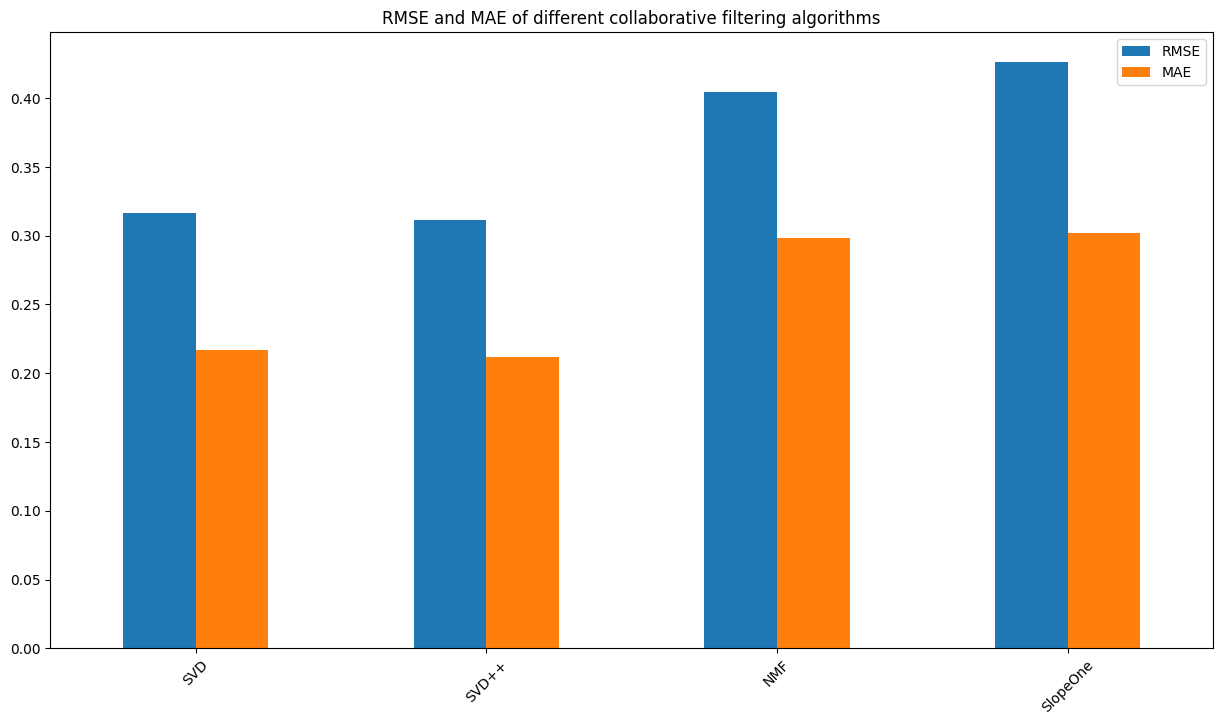

In [153]:
svd = cross_validate(SVD(), data, cv=5, n_jobs=-1, verbose=False)

svdpp = cross_validate(SVDpp(), data, cv=5, n_jobs=-1, verbose=False)

nmf = cross_validate(NMF(), data, cv=5, n_jobs=-1, verbose=False)

slope = cross_validate(SlopeOne(), data, cv=5, n_jobs=-1, verbose=False)


df_results = pd.DataFrame(columns=['Method', 'RMSE', 'MAE'])

df_results.loc[len(df_results)]=['SVD', round(svd['test_rmse'].mean(),5),round(svd['test_mae'].mean(),5)]

df_results.loc[len(df_results)]=['SVD++', round(svdpp['test_rmse'].mean(),5),round(svdpp['test_mae'].mean(),5)]

df_results.loc[len(df_results)]=['NMF', round(nmf['test_rmse'].mean(),5),round(nmf['test_mae'].mean(),5)]

df_results.loc[len(df_results)]=['SlopeOne', round(slope['test_rmse'].mean(),5),round(slope['test_mae'].mean(),5)]

display(df_results)


ax = df_results[['RMSE','MAE']].plot(kind='bar', figsize=(15,8))

ax.set_xticklabels(df_results['Method'].values)

ax.set_title('RMSE and MAE of different collaborative filtering algorithms')

plt.xticks(rotation=45)

matplotlib.rcParams.update({'font.size': 14})

plt.show();